<a href="https://colab.research.google.com/github/MarinaWolters/Coding-Tracker/blob/master/HandsOn10_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIS 545 Recitation 10 - CNN

## Dependency Loading

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.__version__)
print(device)

1.12.1+cu113
cuda:0





## Load the Dataset

### Here we are using the pytorch library to get the dataset and make a dataloader. You will then translate the insights from these tools to solve the image classification problem in HW5.


We are using the Fashion MNIST dataset, a dataset of 28x28 grayscale image, associated with a label from 10 classes (e.g., bag, pullover, trouser). In addition, a walk-through on training a classifier with the CIFAR-10 dataset, another popular dataset, can be found [here](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html).

<img src='https://storage.googleapis.com/tfds-data/visualization/fig/fashion_mnist-3.0.1.png'>

### Transform

#### Here we need to define a series of transformations we want to perform on our dataset before we feed it to the Neural Network.

In [ ]:
train_dataset = torchvision.datasets.FashionMNIST(root = './data', train = True, download= True, transform = transforms.ToTensor())
test_dataset = torchvision.datasets.FashionMNIST(root = './data', train = False, download= True, transform = transforms.ToTensor())

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



## Creating a dataloader. For Train / Test

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 16, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = len(test_dataset), shuffle = True)

## Training Image Visualization

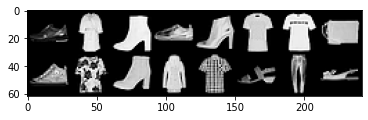

In [ ]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(img.permute(1, 2, 0))
    plt.show()

# get some random training images
data_iter = iter(train_loader)
images, labels = data_iter.next()

# show images
imshow(torchvision.utils.make_grid(images))


## A Basic CNN Model

Check out [here](https://madebyollin.github.io/convnet-calculator/) for a helper calculator you can use for the layer dimensions!

## Check dimension of the input data / labels / Number of classes

In [ ]:
for inputs, labels in train_loader:
    print("The shape of inputs is:", inputs.shape)
    print("The shape of labels is:", labels.shape)
    break

print("Number of classes:", len(train_dataset.classes))

The shape of inputs is: torch.Size([16, 1, 28, 28])
The shape of labels is: torch.Size([16])
Number of classes: 10


## Defining CNN Architecture

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO
        # in_channels = 1 : Grayscale img
        self.conv = nn.Conv2d(in_channels = 1, out_channels=20, kernel_size=4, stride=2)
        self.relu = nn.ReLU()

        self.mp = nn.MaxPool2d(kernel_size = 2)

        self.flatten = nn.Flatten(start_dim=1)

        self.fc = nn.Linear(in_features = 20 * 3 * 3, out_features=10)
    def forward(self, x):
        # TODO
        outputs = self.mp(self.relu(self.conv(x)))
        outputs = self.flatten(outputs)
        #print(outputs.shape)
        outputs = self.fc(outputs)
        
        return outputs

## Train the CNN

In [ ]:
# Sending the data to device (CPU or GPU)
cnn = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=1e-4) #lr - learning step

loss_LIST = []

# Epochs 3
for epoch in range(3):
  running_loss = 0.0
  for inputs, labels in train_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      
      outputs = cnn(inputs) # Feed the network the train data
      optimizer.zero_grad() # We need to reset the optimizer tensor gradient every mini-batch
      loss = criterion(outputs, labels) # this is the average loss for one mini-batch of inputs
      loss.backward() # Do a back propagation
      optimizer.step() # Update the weight using the gradients from back propagation by learning step

      running_loss += loss.item() #get the accumulated loss for each epoch
  loss_LIST.append(running_loss / len(train_loader)) # get the avg loss for each epoch
  
  # print statistics
  print(f'The loss for Epoch {epoch} is: {running_loss/len(train_loader)}')

The loss for Epoch 0 is: 1.3343308279593786
The loss for Epoch 1 is: 0.7466506271839142
The loss for Epoch 2 is: 0.6479623241941134


## Calculating the Test Set Accuracy

In [ ]:
total = 0
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = cnn(images) # shape: torch.Size([10000, 10])
        _, predicted = torch.max(outputs.data, 1) # use max to get the prediction
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {100 * correct / total}')

Test Accuracy: 77.14
